# Cronavirus cases correlation

In [9]:
# update data
!git submodule update
!cd COVID-19/; git pull

Already up to date.


In [10]:
import pandas as pd
import pylab

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8] # w, h

min_number_cases=100
min_number_cases_date='3/5/20'  # today date
zero_ref=100

data_folder = "./COVID-19/csse_covid_19_data/csse_covid_19_time_series"
file_name = {
    "confirmed": "{}/time_series_covid19_confirmed_global.csv".format(data_folder),
    "death": "{}/time_series_covid19_deaths_global.csv".format(data_folder),
    "recover": "{}/time_series_covid19_recovered_global.csv".format(data_folder)
}

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression

def process_df(df, zero_ref=100):
    data = {}
    for country, row in df.iterrows():
        cases = row.to_list()
        new_i, zero_i = 0, 0
        start = False
        for i in range(len(cases)):
            if row[i] >= zero_ref:
                zero_i = i
                break
        new_i = [i-zero_i for i in range(len(cases))]
        data[country] = {"cases": cases, "index": new_i}
    return data    
    
def plot_dict(dict_c, xlim, xlabel, ylabel, titlestr):
    fig = plt.figure()
    plt.title(titlestr)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = fig.add_subplot(1, 1, 1)
    for country in dict_c:
        y, x = dict_c[country]["cases"], dict_c[country]["index"]
        #plt.plot(x, y, '.-', linewidth=2, markersize=12)
        if country == 'US':
            line, = ax.plot(x, y, '*--', lw=1, color='r', label=country)
        else:
            line, = ax.plot(x, y, '.-', lw=2, label=country)
    ax.grid(which='both', b=True)
    ax.set_xlim(0,+xlim)
#     ax.set_ylim(100,10**4)
    ax.legend()
    ax.set_yscale('log')
    pylab.show()

def plot_csv_file(file_type, min_number_cases=150, min_number_cases_date='3/6/20', zero_ref=100, xlim=15):
    file_path = file_name[file_type]
    df_c = pd.read_csv(file_path) 
    df_c = df_c.drop(['Lat', 'Long', 'Province/State'], axis=1)
    df_c = df_c.groupby(['Country/Region']).sum()
    df_c = df_c.loc[df_c[min_number_cases_date] >= min_number_cases]
    
    df_dict = process_df(df_c, zero_ref)
    
    titlestr = file_type
    xlabel = 'days since {} number of people {}'.format(min_number_cases, file_type)
    ylabel = 'people number'
    plot_dict(df_dict, xlim, xlabel, ylabel, titlestr)

def forecast(file_type, country, zero_ref):
    file_path = file_name[file_type]
    df_c = pd.read_csv(file_path) 
    df_c = df_c.drop(['Lat', 'Long', 'Province/State'], axis=1)
    df_c = df_c.groupby(['Country/Region']).sum()
    df_dict = process_df(df_c, zero_ref)
#     y = df_dict[country]
    y = pd.DataFrame.from_dict(df_dict[country]).set_index('index')['cases']
    
    y = y.loc[0:]
    dy = y.diff()[1:]
    y = y.loc[1:]
    y_log = np.log(y)
    dy_log = np.log(dy)
    
    X, Y = y_log.index.to_list(), y_log.to_list()
    X, Y = np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1)
    reg = LinearRegression().fit(X, Y)
    
    X_ = X + 7
    p_dy = reg.predict(X_)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    line, = ax.plot(X, np.exp(Y), '-', lw=1, color='b', label='actual')
    line, = ax.plot(X_, np.exp(p_dy), '*--', lw=1, color='r', label='predict')
    
    ax.legend()
#     ax.set_yscale('log')
    ax.grid(which='both', b=True)
    pylab.show()
    print(np.exp(p_dy))
    print(np.diff(np.exp(p_dy)))

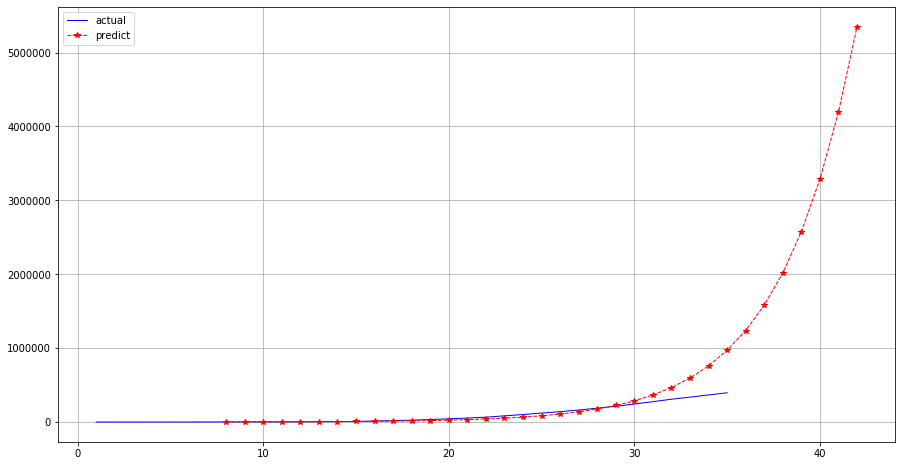

[[1.34150680e+03]
 [1.71197232e+03]
 [2.18474423e+03]
 [2.78807505e+03]
 [3.55801948e+03]
 [4.54058889e+03]
 [5.79450100e+03]
 [7.39468882e+03]
 [9.43677854e+03]
 [1.20428042e+04]
 [1.53685001e+04]
 [1.96126079e+04]
 [2.50287526e+04]
 [3.19405997e+04]
 [4.07611968e+04]
 [5.20176571e+04]
 [6.63826595e+04]
 [8.47146476e+04]
 [1.08109129e+05]
 [1.37964144e+05]
 [1.76063808e+05]
 [2.24684933e+05]
 [2.86733087e+05]
 [3.65916229e+05]
 [4.66966292e+05]
 [5.95921964e+05]
 [7.60489554e+05]
 [9.70503518e+05]
 [1.23851415e+06]
 [1.58053761e+06]
 [2.01701299e+06]
 [2.57402379e+06]
 [3.28485661e+06]
 [4.19199038e+06]
 [5.34963483e+06]]
[]


In [12]:
forecast("confirmed", "US", 100)

/Users/haoyuhe/work/fastquant/goquant/env/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


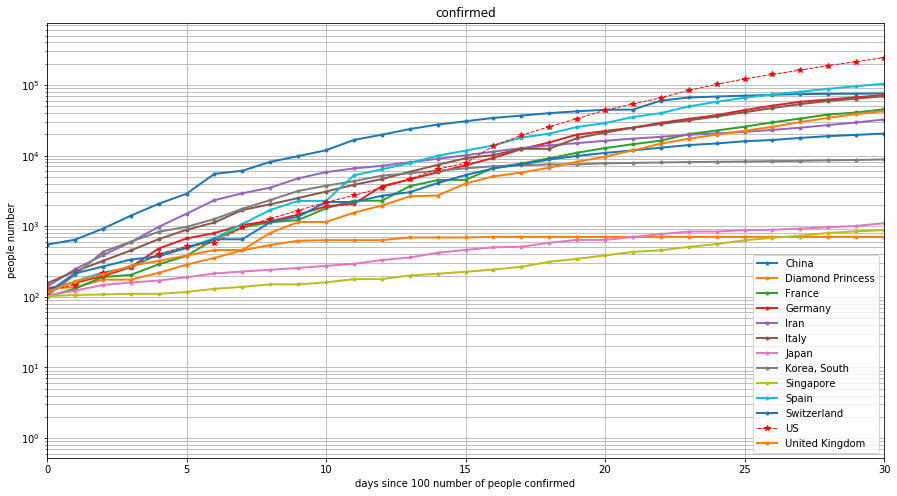

In [13]:
plot_csv_file("confirmed",
              min_number_cases=min_number_cases, 
              min_number_cases_date=min_number_cases_date, 
              zero_ref=zero_ref,
             xlim=30)